In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection

import math
import sys
import numpy
import random
import time
import steps.model as smodel
import steps.solver as solvmod
import steps.mpi.solver as mpisolvmod
import steps.geom as stetmesh
import steps.rng as srng
import steps.utilities.meshio as smeshio
import steps.utilities.meshctrl as meshctrl

def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█'):
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    sys.stdout.write('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix))
    sys.stdout.flush()
    # Print New Line on Complete
    if iteration == total: 
        print()

-----------------------------------------------------------------
STEPS is running in parallel mode with  1  processes
-----------------------------------------------------------------


Text(0.5, 1.0, 'Concentration vs. distance and time')

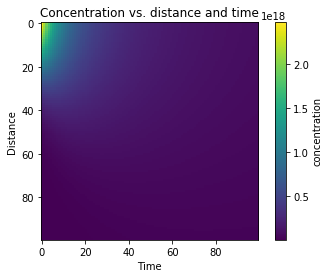

In [2]:
%matplotlib inline
D = 0.0002
N = 1e9
R = np.linspace(0.0001,0.001,100)
T = np.linspace(0.0001,0.001,100)
C = np.zeros((len(R),len(T)))
for r in range(len(R)):
    for t in range(len(T)):
        C[r,t] = (N/(8*np.pi*D*T[t])**(3/2)*np.exp(-R[r]**2/(4*D*T[t])))
plt.imshow(C)
plt.ylabel('Distance')
plt.xlabel('Time')
plt.colorbar(label='concentration')
plt.title('Concentration vs. distance and time')

In [3]:
# The diffusion constant for our diffusing species (m^2/s)
DCST = 0.2e-12
cbaryc = [0, 0, 0]
SCALING_FACTOR = 1e-6 # whole to micro
AZ_RADIUS = 0.15 * SCALING_FACTOR
azCaChN = 150

In [4]:
SCALING_FACTOR

1e-06

In [5]:

# mesh, nodeproxy, tetproxy, triproxy = smeshio.importAbaqus('meshes/cyl_1.inp', 1)
# mesh, nodeproxy, tetproxy, triproxy = smeshio.importAbaqus('meshes/3cyl.inp', 0.5)
# mesh, nodeproxy, tetproxy, triproxy = smeshio.importAbaqus('meshes/cyl_r300_h800_er.inp', 1)
mesh, nodeproxy, tetproxy, triproxy = smeshio.importAbaqus('meshes/cyl4.inp', SCALING_FACTOR)

tetgroups = tetproxy.blocksToGroups()
CS_tet_IDs = tetgroups['cytosol']
ER_tet_IDs = tetgroups['ER']
print("=======================================================")
print("                   GEOMETRY STATS:                     ")
print("=======================================================")
print("_______________________________________________________")

print('number of tets in CS: ', CS_tet_IDs.__len__())
print('number of tets in ER: ', ER_tet_IDs.__len__())
print('overlapping tets in CS and ER:', set(CS_tet_IDs).intersection(ER_tet_IDs))  

ERvol = sum([mesh.getTetVol(i) for i in ER_tet_IDs])
CSvol = sum([mesh.getTetVol(i) for i in CS_tet_IDs])

print('ER volume: {:.4f} um3'.format(ERvol * 1e18))
print('CS volume: {:.4f} um3'.format(CSvol * 1e18))
print('Total vol: {:.4f} um3'.format((CSvol + ERvol) * 1e18))

print("_______________________________________________________")
# # get tris in BOTTOM FACE:
# z = 0
# cbaryc = [0, 0, z]
# trirads = np.zeros((mesh.ntris,))
# in_bottom = np.zeros((mesh.ntris,), dtype='bool')
# for triID in range(mesh.ntris):
#     baryc = mesh.getTriBarycenter(triID)
#     r = math.sqrt(math.pow((baryc[0]-cbaryc[0]),2) \
#                     + math.pow((baryc[1]-cbaryc[1]),2) \
#                         + math.pow((baryc[2]-cbaryc[2]),2))
#     trirads[triID] = r
#     in_bottom[triID] = True if baryc[2] == z else False
# zipped = zip(trirads, range(mesh.ntris), in_bottom)
# zipped = sorted(zipped, key=lambda x: x[0])
# bottom_tris = [i[1] for i in zipped if i[2]==True]

# print('Tris in BOTTOM FACE: ', len(bottom_tris))
# print("_______________________________________________________")

# # get tris in AZ:
# z = 0
# BARYC = []
# cbaryc = [0, 0, z]
# trirads = np.zeros((mesh.ntris,))
# in_bottom = np.zeros((mesh.ntris,), dtype='bool')
# for triID in range(mesh.ntris):
#     baryc = mesh.getTriBarycenter(triID)
#     BARYC.append(baryc)
#     r = math.sqrt(math.pow((baryc[0]-cbaryc[0]),2) \
#                     + math.pow((baryc[1]-cbaryc[1]),2) \
#                         + math.pow((baryc[2]-cbaryc[2]),2))
#     trirads[triID] = r
#     in_bottom[triID] = True if baryc[2] == z else False
# zipped = zip(trirads, range(mesh.ntris), in_bottom)
# zipped = sorted(zipped, key=lambda x: x[0])
# az_tris = [i[1] for i in zipped if i[0]<AZ_RADIUS and i[2]==True]
# print('Tris in AZ: ', len(az_tris))
# print("_______________________________________________________")

# get tets and tris in AZ:

triBARYC = []
surftris = mesh.getSurfTris()

surftrirads, in_az = [], []
for surftriID in surftris:
    baryc = mesh.getTriBarycenter(surftriID)
    triBARYC.append(baryc)
    r = math.sqrt(math.pow((baryc[0]-cbaryc[0]),2) \
                    + math.pow((baryc[1]-cbaryc[1]),2) \
                        + math.pow((baryc[2]-cbaryc[2]),2))
    surftrirads.append(r)
    in_az.append(True if r <= AZ_RADIUS else False)
zipped0 = zip(surftrirads, surftris, in_az)
zipped0 = sorted(zipped0, key=lambda x: x[0])
az_tris = [i[1] for i in zipped0 if i[0]<AZ_RADIUS and i[2]==True]

# get surface tetrahedrons within the active zone:
az_tets = [mesh.getTriTetNeighb(i)[0] for i in az_tris]

# get the triangles of those AZ tetrahedrons:
az_tet_tris = []
for az_tet in az_tets:
    az_quart = mesh.getTetTriNeighb(az_tet)
    for i in az_quart:
        az_tet_tris.append(i)
az_area = sum([mesh.getTriArea(i) for i in az_tris])
print('Tris in AZ: ', len(az_tris))
print('Tets in AZ: ', len(az_tets))
print('AZ area {:.4f} um2'.format(az_area * 1e12))
print("_______________________________________________________")

memb_area = sum([mesh.getTriArea(i) for i in surftris])
print('Memb. area {:.4f} um2'.format(memb_area * 1e12))
print("_______________________________________________________")

print('Furtest distances along axes (x, y, z)')
for ax in range(3):
    print('{:.4f} um'. format(max([triBARYC[i][ax] for i in range(len(triBARYC))]) * 1e6))
    
print('Minimum distances along axes (x, y, z)')
for ax in range(3):
    print('{:.4f} um'. format(min([triBARYC[i][ax] for i in range(len(triBARYC))]) * 1e6))
print("_______________________________________________________")

CaSensTris = [zipped0[i][1] for i in range(6)]
NotCaSensTris = list(set(az_tris)-set(CaSensTris))
print('NotCaSensTris:  {}'.format(NotCaSensTris))
print('Ca sensor tris: {}'.format(CaSensTris))
CaSensTets = [mesh.getTriTetNeighb(i)[0] for i in CaSensTris]
NotCaSensTets = list(set(az_tets)-set(CaSensTets))
print('NotCaSensTets: {}'.format(len(NotCaSensTets)))
print('CaSensTets:    {}'.format(len(CaSensTets)))

Reading Abaqus file...
Number of nodes imported:  21585
Number of tetrahedrons imported:  121063
Number of triangles imported:  0
creating Tetmesh object in STEPS...
Tetmesh object created.
                   GEOMETRY STATS:                     
_______________________________________________________
number of tets in CS:  116284
number of tets in ER:  4779
overlapping tets in CS and ER: set()
ER volume: 0.0139 um3
CS volume: 0.3671 um3
Total vol: 0.3810 um3
_______________________________________________________
Tris in AZ:  168
Tets in AZ:  168
AZ area 0.0705 um2
_______________________________________________________
Memb. area 2.5422 um2
_______________________________________________________
Furtest distances along axes (x, y, z)
0.4497 um
0.4497 um
0.8993 um
Minimum distances along axes (x, y, z)
-0.4496 um
-0.4494 um
0.0007 um
_______________________________________________________
NotCaSensTris:  [94208, 97805, 78862, 85007, 83984, 120336, 96270, 84499, 122386, 116750, 82963, 1

<img src="images/Bouton.png" alt="Drawing" style="width: 350px;"/>

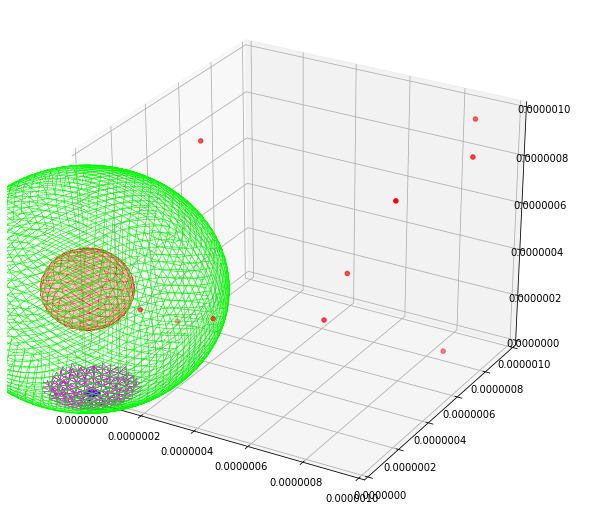

In [6]:
%matplotlib inline

def draw_polygon_coll(ax, mesh, tris, sf=1, ln=1, pg=1, c=[0,0,1], alpha=0.1, linewidths=0.5, linestyles=':'):
    Pcoll = []
    for triID in tris:
        P = []
        for verID in mesh.getTri(triID):
            triVertex = tuple(mesh.getVertex(verID))
            P.append(triVertex)
        Pcoll.append(P)
    if ln==1:
        collection = Line3DCollection(Pcoll, colors=c, linewidths=linewidths, linestyles=linestyles)
        ax.add_collection3d(collection)
    if pg==1:
        collection = Poly3DCollection(Pcoll)
        collection.set_facecolor((c[0], c[1], c[2], alpha))
        
    ax.add_collection3d(collection)
    ax.set_xlim(0, SCALING_FACTOR)
    ax.set_ylim(0, SCALING_FACTOR)
    ax.set_zlim(0, SCALING_FACTOR)

fig = plt.figure(figsize=(8,7))
ax = Axes3D(fig)

all_ER_tris = meshctrl.findOverlapTris(mesh, CS_tet_IDs, ER_tet_IDs)
all_surf_tris = mesh.getSurfTris()
cent_tet = mesh.findTetByPoint([0,0,0])
cent_tets = mesh.getTetTriNeighb(cent_tet)



# draw_polygon_coll(ax, mesh, cent_tets, sf=SCALING_FACTOR, pg=1, ln=1, c=[0,0,1], alpha=0.3, linewidths=0.5, linestyles=':')
draw_polygon_coll(ax, mesh, all_ER_tris, sf=SCALING_FACTOR, pg=1, ln=1, c=[1,0,0], alpha=0.1, linewidths=0.5, linestyles=':')
# draw_polygon_coll(ax, mesh, az_tris, sf=SCALING_FACTOR, pg=1, ln=1, c=[0,0,1], alpha=0.9, linewidths=0.5, linestyles=':')
draw_polygon_coll(ax, mesh, all_surf_tris, sf=SCALING_FACTOR, pg=0, ln=1, c=[0,1,0], alpha=0.1, linewidths=0.5, linestyles=':')
draw_polygon_coll(ax, mesh, az_tet_tris, sf=SCALING_FACTOR, pg=0, ln=1, c=[1,0,1], alpha=0.9, linewidths=0.4, linestyles='-')
draw_polygon_coll(ax, mesh, CaSensTris, sf=SCALING_FACTOR, pg=1, ln=0, c=[0,0,1], alpha=0.9, linewidths=1, linestyles='-')


x =np.random.rand(1, 10) * SCALING_FACTOR
y =np.random.rand(1, 10) * SCALING_FACTOR
z =np.random.rand(1, 10) * SCALING_FACTOR
ax.scatter(x, y, z, c='r', marker='o')

In [7]:
model = smodel.Model()

vsys0 = smodel.Volsys('vsys0', model) # cytosol
vsys1 = smodel.Volsys('vsys1', model) # ER

surfsys0 = smodel.Surfsys('surfsys0', model) # cytosol membrane
# surfsys1 = smodel.Surfsys('surfsys1', model) # bottom face of the cylinder EXCLUDING the AZ
surfsys2 = smodel.Surfsys('surfsys2', model) # ER memb

Ca = smodel.Spec('Ca', model)
Ca_Ch = smodel.Spec('Ca_Ch', model)
Ca_sens = smodel.Spec('Ca_sens', model)
Ca_sens_b = smodel.Spec('Ca_sens_b', model)

diff_Ca_cyt  = smodel.Diff('diff_Ca_cyt',  vsys0,    Ca,         DCST) # name, where, what, how fast
diff_Ca_ER  = smodel.Diff('diff_Ca_ER',    vsys1,    Ca,         DCST) # name, where, what, how fast
# diff_Ca_sens    = smodel.Diff('diff_Ca_sens', surfsys2, Ca_sens,  DCST) # name, where, what, how fast

# define compartments:
cyto_comp = stetmesh.TmComp('cyto_comp', mesh, CS_tet_IDs)
ER_comp = stetmesh.TmComp('ER_comp', mesh, ER_tet_IDs)

# get surf tris in comps:
CS_memb_tris = meshctrl.findSurfTrisInComp(mesh, cyto_comp)
ER_memb_tris = meshctrl.findOverlapTris(mesh, CS_tet_IDs, ER_tet_IDs)

# patches:
ER_surf = stetmesh.TmPatch('ER_surf', mesh, ER_memb_tris, icomp = ER_comp, ocomp = cyto_comp)
memb_surf = stetmesh.TmPatch('memb_surf', mesh, CS_memb_tris, icomp = cyto_comp)
# AZ_surf     = stetmesh.TmPatch('AZ_surf',         mesh, az_tris,     icomp = cyto_comp)

reac1 = smodel.SReac('reac1', surfsys2, olhs=[Ca], slhs=[Ca_sens], srhs=[Ca_sens_b], kcst=5e8)
reac2 = smodel.SReac('reac2', surfsys0, slhs=[Ca_Ch], srhs=[Ca_Ch], irhs=[Ca], kcst=0)

# add volume systems (with all their reactions and diff rules) to compartments:
cyto_comp.addVolsys('vsys0')
ER_comp.addVolsys('vsys1')
memb_surf.addSurfsys('surfsys0')
# not_az_surf.addSurfsys('surfsys1')
ER_surf.addSurfsys('surfsys2')

In [8]:
# Print geom stats:

cyt_vol = 0;
for tets in CS_tet_IDs:
    cyt_vol += mesh.getTetVol(tets)
print ("Cytosol volume =\t", cyt_vol)

cyt_memb_area = 0;
for tri in CS_memb_tris:
    cyt_memb_area += mesh.getTriArea(tri)
print ("Cytosol memb. area =\t", cyt_memb_area)

cyt_vol = 0;
for tets in ER_tet_IDs:
    cyt_vol += mesh.getTetVol(tets)
print ("Endoplasmic R. volume =\t", cyt_vol)

ER_memb_area = 0;
for tri in ER_memb_tris:
    ER_memb_area += mesh.getTriArea(tri)
print ("Endoplasmic R. area =\t", ER_memb_area)

# az_area = 0
# for tri in az_tris:
#     az_area += mesh.getTriArea(tri)
# print ("Active Zone area =\t", az_area)
# print ("Active Zone radius =\t", AZ_RADIUS)

Cytosol volume =	 3.6713520385720355e-19
Cytosol memb. area =	 2.5421859160028213e-12
Endoplasmic R. volume =	 1.3890287712369775e-20
Endoplasmic R. area =	 2.8001146334879154e-13


# we define reactions and diffusion rules in volume/surface systems and then put these systems into compartments/patches

In [9]:
def ResetSim (sim, model, mesh, rng):
    sim.reset()
    reac2.kcst = 0
    #populate the active zone (except the sensor tets) with Ca channels randomly:
    for i in range(len(NotCaSensTris)):
        rnd_az_tri = np.random.choice(NotCaSensTris)
        sim.setTriCount(rnd_az_tri, 'Ca_Ch', sim.getTriCount(rnd_az_tri, 'Ca_Ch') + 1)
    sim.setPatchCount('ER_surf', 'Ca_sens', 1e4)
    sim.setCompCount('cyto_comp', 'Ca', 0)
    return sim


def OpenCaChans(sim, NotCaSensTets, NotCaSensTris):
#     for i in range(len(NotCaSensTets)):
#         rnd_az_tet = np.random.choice(NotCaSensTets)
#         prev = sim.getTetCount(rnd_az_tet, 'Ca')
#         sim.setTetCount(rnd_az_tet, 'Ca', prev + 1)
#         new = sim.getTetCount(rnd_az_tet, 'Ca')
#         total_in_az = sum([sim.getTetCount(j, 'Ca') for j in NotCaSensTets])
#         print(rnd_az_tet, prev, new, total_in_az)
#     print('++++++++++++', total_in_az)
#     return sim
    return sim


rng = srng.create('mt19937', 512)
rng.initialize(2903)
sim = solvmod.Tetexact(model, mesh, rng)

In [10]:
CA_FLUX_ONSET = 0.02
CA_FLUX_OFFSET = 0.03

# The number of iterations to run
NITER = 1

# The data collection time increment (s)
DT = 0.001

# The simulation endtime (s)
T = 0.07

sim = solvmod.Tetexact(model, mesh, rng)

# initialize a progressbar:
pbarlen = 50

tpnts = numpy.arange(0.0, T, DT)
ntpnts = tpnts.shape[0]
res = numpy.zeros((NITER, ntpnts, len(CS_tet_IDs)))

for i in range(NITER):
    sim = ResetSim(sim, model, mesh, rng)
    print('Iteration', i)
    printProgressBar(0, NITER, prefix = 'Progress:', suffix = 'Complete', length = pbarlen)
    for j in range(ntpnts):
        if tpnts[j] > CA_FLUX_ONSET:
            sim.setPatchSReacK('memb_surf', 'reac2', 5e4)
        if tpnts[j] < CA_FLUX_OFFSET:
            sim.setPatchSReacK('memb_surf', 'reac2', 0)
#             sim = OpenCaChans(sim, NotCaSensTets, NotCaSensTris)
        sim.run(tpnts[j])
        c = 0
        for tet in CS_tet_IDs:
            res[i, j, c] = sim.getTetCount(tet, 'Ca')
            c += 1
        printProgressBar(j + 1, ntpnts, prefix='Progress:', suffix='Complete', length=pbarlen)
res_mean = numpy.mean(res, axis=0)

Iteration 0
Progress: |██████████████████████████████████████████████████| 100.0% Complete


In [12]:
print('Unbound Ca receptors on ER memb: {}'.format(sim.getPatchCount('ER_surf', 'Ca_sens')))
print('Bound Ca receptors on ER memb:   {}'.format(sim.getPatchCount('ER_surf', 'Ca_sens_b')))
print('Free Ca in cytosol:              {}'.format(sim.getCompCount('cyto_comp', 'Ca')))
print('Free Ca in ER:                   {}'.format(sim.getCompCount('ER_comp', 'Ca')))
print('Free Ca in AZ around SensTets:   {}'.format(
    sum([sim.getTetCount(i, 'Ca') for i in NotCaSensTets])))
print('Free Ca in SensTet tets:         {}'.format(
    sum([sim.getTetCount(i, 'Ca') for i in CaSensTets])))

Unbound Ca receptors on ER memb: 8876.0
Bound Ca receptors on ER memb:   1124.0
Free Ca in cytosol:              322963.0
Free Ca in ER:                   0.0
Free Ca in AZ around SensTets:   22464.0
Free Ca in SensTet tets:         1009.0


### Plotting simulation output
So now we come to plotting our data. Now that we have spatial information the data we wish to plot is different to our previous well-mixed simulations where we were plotting the concentration in a well-mixed compartment. We will plot the mean concentration from individual tetrahedrons against their radial distance from origin, but at many different time points. To achieve this we will create another function, this time with a parameter relating to the “time point“ we wish to plot. We can then call this function with a “time point“ argument and our function will plot concentration vs radial distance at the time relating to that “time point“, as desired. In our function we also label the axis and title the plot with the time.


In [ ]:
%matplotlib inline 
import matplotlib.pyplot as plt

def plotres(res_mean, tidx):
    if tidx >= INT / DT:
        print("Time index is out of range.")
        return

    plt.scatter(tetrads, res_mean[tidx], s=2)
    plt.xlabel('Radial distance of tetrahedron ($\mu$m)')
    plt.ylabel('Concentration in tetrahedron ($\mu$M)')
    t = tpnts[tidx]
    plt.title('Unbounded diffusion. Time: ' + str(t) + 's')
    plotanlyt(t)
    plt.xlim(0.0, 10.0)
    plt.ylim(0.0)

You may have noticed that we call a function that we have not defined yet, `plotanlyt`. This function will plot the concentration from the analytical concentration given by our equation. The function for plotting the analytical solution is provided here, but we will not go through this code in detail. Here we can see why the diffusion constant was stored in variable `DCST` at the top of our script:

In [ ]:
def plotanlyt(t):
    segs = 100
    anlytconc = numpy.zeros(segs)
    radialds = numpy.zeros(segs)
    maxrad = 0.0
    for i in tetrads:
        if i > maxrad: maxrad = i
    maxrad *= 1e-6
    intervals = maxrad / segs
    rad = 0.0
    for i in range(segs):
        # Find the conc from analytical solution, and convert to mol/L         
        anlytconc[i] = 1.0e3 * (1 / 6.022e23) * \
                ((NINJECT / (math.pow((4 * math.pi * DCST * t), 1.5))) * \
                (math.exp((-1.0 * (rad * rad)) / (4 * DCST * t))))
        radialds[i] = rad * 1e6
        rad += intervals
    plt.plot(radialds, anlytconc, color='red')

And that is everything we need to set up and run our simple diffusion simulation and plot the data, alongside the analytical solution for comparison. With this structure, it is intended that the plotting functions is called interactively, giving us the chance to visualise a number of different time plots, then save whichever plots we chose. It often makes sense to output the data to a file, then write plotting functions in separate modules that can load the saved data from these files and plot. This requires some knowledge of writing and reading files in Python, but like most operations in Python, can usually be picked up quite quickly.

Let’s assume we have contained all of our unbounded diffusion code from this chapter in a Python file diffusion.py (which can be found in examples/tutorial). We can then run our simulation interactively in Python by importing the module, then visualising the data with the plotres function we defined. For this example lets provide a call to our plotres function with argument 100 meaning we will plot data at “time point“ 100 (corresponding to time 0.1s), our last “time point“:

In [ ]:
plt.figure(figsize=(10,6))
plotres(res_mean, 100)

### Simulation with TetOpSplit

Version 2.3 and later of STEPS include an approximate spatial stochastic solver called `TetOpSplit` ([steps.mpi.solver.TetOpSplit](API_mpisolver.rst#steps.mpi.solver.TetOpSplit)). This solver applies an approximation for diffusion whereas reactions are solved by the SSA. The solver is designed to approximate the exact solver, `Tetexact`, to high accuracy and may perform significantly faster then Tetexact for some models. A full description of the method is available at: [http://arxiv.org/abs/1512.03126](http://arxiv.org/abs/1512.03126). Although the method differs significantly from the exact stochastic solver, usage is very similar with only one different command necessary in this example to simulate the model with `TetOpSplit` instead of `Tetexact`. That is, instead of creating a Tetexact solver object we create a TetOpSplit solver object with the following command:


In [ ]:
import steps.mpi.solver as mpisolvmod
 
sim_tos = mpisolvmod.TetOpSplit(model, tmgeom, rng, False, \
                                [0] * tmgeom.ntets)

The model can be run with the exact same set of Python commands as for the previous simulation with `Tetexact`, using the reference to the `TetOpSplit` object `sim_tos,` writing over the data recorded to `NumPy` array res and recreating res_mean for use by the plotting function:

In [ ]:
# Run NITER number of iterations:
for i in range(NITER):
    sim_tos.reset()
    # Inject all molecules into the central tet:
    sim_tos.setTetCount(ctetidx, 'A', NINJECT)
    for j in range(ntpnts):
        sim_tos.run(tpnts[j])
        # Loop over the tetrahedrons we are saving data for
        for k in range(SAMPLE):
            # Save the concentration in the tetrahedron, in uM
            res[i, j, k] = sim_tos.getTetConc(int(tetidxs[k]), 'A') * 1.0e6

res_mean = numpy.mean(res, axis=0)

We can now plot the results obtained with `TetOpSplit`

In [ ]:
plt.figure(figsize=(10, 6))
plotres(res_mean, 100)